# GPcounts applied to scRNA-Seq time series data

Nuha BinTayyash, 2020

GPcounts is a Gaussian process regression package for counts data with negative binomial and zero-inflated negative binomial likelihoods as described in the paper "Non-parametric modelling of temporal and spatial counts data from RNA-seq experiments".


This notebook shows how to fit GPcounts with negative binomial likelihood using full inference on ScRNA-seq gene expression data in Islet $\alpha$ cell from [GSE8737 single cell RNA-seq ](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE87375) dataset to find differentially expressed genes using one sample test and compare it with GPcounts with sparse inferece to obtain to obtain computational efficiency.

In [1]:
import pandas as pd
import numpy as np
import gpflow 
from IPython.display import display

Load $\alpha$ gene expression data and pseudotime information

In [2]:
Y = pd.read_csv('../data/normalized_alpha_counts.csv',index_col=[0])
X = pd.read_csv('../data/alpha_time_points.csv',index_col=[0])

In [3]:
from GPcounts.GPcounts_Module import Fit_GPcounts

In [4]:
genes_name = ['ENSMUSG00000015879','ENSMUSG00000059173']
gp_counts = Fit_GPcounts(X,Y.loc[genes_name],safe_mode = True) 

Probabilty of zeros in Fam184b and Pde1a genes

In [5]:
Y.loc[genes_name][Y.loc[genes_name] == 0].count(axis=1)/len(Y.columns)

ENSMUSG00000015879    0.859756
ENSMUSG00000059173    0.628049
dtype: float64

Load GPflow models and plot GP posterior predictive distribution

## 1. Fit GPcounts with different negative binomial likelihood assuming full inference on Fam184b and Pde1a genes

In [6]:
likelihood = 'Zero_inflated_negative_binomial' # choose the likelihood
results = gp_counts.One_sample_test(likelihood)
display(results)

  0%|          | 0/2 [00:00<?, ?it/s]

{'ls': 0.05, 'var': 1.9535154797430865, 'alpha': 1.0, 'km': 35.0}
{'ls': 1000.0, 'var': 1.9535154797430865, 'alpha': 1.0, 'km': 35.0}


 50%|█████     | 1/2 [00:48<00:48, 48.17s/it]

{'ls': 0.05, 'var': 4.7156660862377, 'alpha': 1.0, 'km': 35.0}
{'ls': 1000.0, 'var': 4.7156660862377, 'alpha': 1.0, 'km': 35.0}


100%|██████████| 2/2 [01:08<00:00, 34.18s/it]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
ENSMUSG00000015879,-354.496928,-357.560462,3.063534
ENSMUSG00000059173,-758.201393,-784.106171,25.904778


In [7]:
test_name = 'One_sample_test' # name of the test
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)

  0%|          | 0/2 [00:00<?, ?it/s]

{'ls': 0.05, 'var': 1.9535154797430865, 'alpha': 1.0, 'km': 35.0}
{'ls': 1000.0, 'var': 1.9535154797430865, 'alpha': 1.0, 'km': 35.0}


 50%|█████     | 1/2 [00:01<00:01,  1.09s/it]

{'ls': 0.05, 'var': 4.7156660862377, 'alpha': 1.0, 'km': 35.0}
{'ls': 1000.0, 'var': 4.7156660862377, 'alpha': 1.0, 'km': 35.0}


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


ENSMUSG00000015879


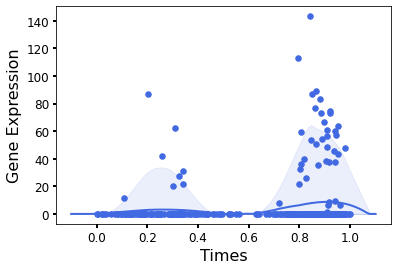

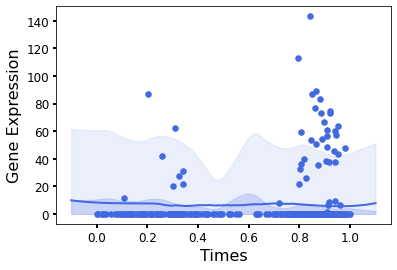

ENSMUSG00000059173


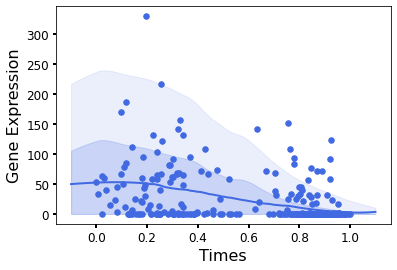

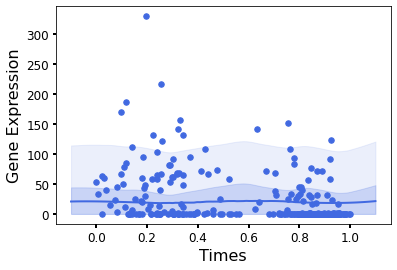

In [8]:
from helper import plot 
plot(params,X.values,Y.loc[genes_name])

### 2. Fit GPcounts with negative binomial likelihood assuming sparse inference to obtain computational efficiency on Fam184b and Pde1a genes

First we create a new GPcounts object to containing the sparse option

In [9]:
sparse = True 
gp_counts = Fit_GPcounts(X,Y.loc[genes_name],sparse = sparse,safe_mode = True) 

In [10]:
results = gp_counts.One_sample_test(likelihood)
display(results)

  0%|          | 0/2 [00:00<?, ?it/s]

{'ls': 0.05, 'var': 1.9535154797430865, 'alpha': 1.0, 'km': 35.0}
{'ls': 1000.0, 'var': 1.9535154797430865, 'alpha': 1.0, 'km': 35.0}


 50%|█████     | 1/2 [00:13<00:13, 13.97s/it]

{'ls': 0.05, 'var': 4.7156660862377, 'alpha': 1.0, 'km': 35.0}
{'ls': 1000.0, 'var': 4.7156660862377, 'alpha': 1.0, 'km': 35.0}


100%|██████████| 2/2 [00:17<00:00,  8.80s/it]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
ENSMUSG00000015879,-379.976966,-357.568811,0.00000
ENSMUSG00000059173,-783.575874,-784.107533,0.53166


  0%|          | 0/2 [00:00<?, ?it/s]

{'ls': 0.05, 'var': 1.9535154797430865, 'alpha': 1.0, 'km': 35.0}
{'ls': 1000.0, 'var': 1.9535154797430865, 'alpha': 1.0, 'km': 35.0}


 50%|█████     | 1/2 [00:00<00:00,  1.31it/s]

{'ls': 0.05, 'var': 4.7156660862377, 'alpha': 1.0, 'km': 35.0}
{'ls': 1000.0, 'var': 4.7156660862377, 'alpha': 1.0, 'km': 35.0}


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


ENSMUSG00000015879


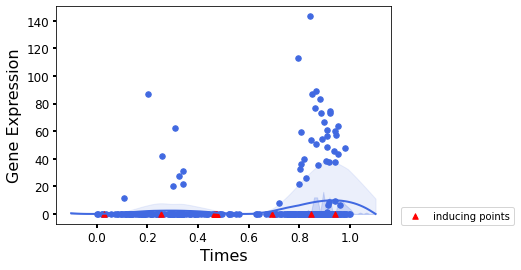

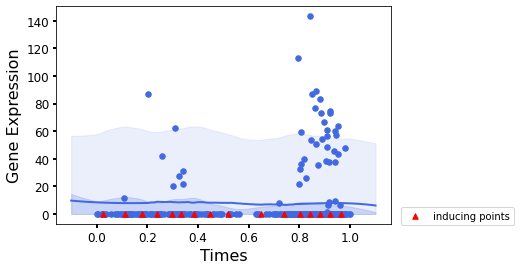

ENSMUSG00000059173


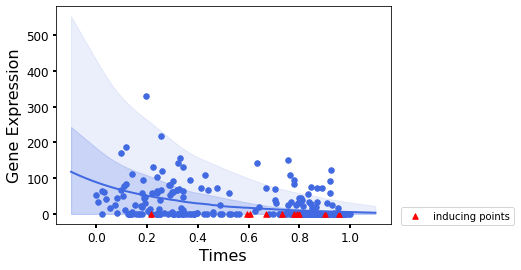

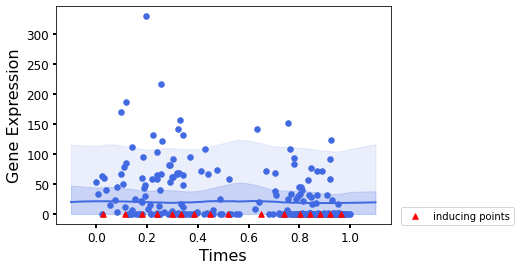

In [11]:
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.values,Y.loc[genes_name],sparse)